In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [2]:
pip install --upgrade scipy networkx

  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: networkx
    Found existing installation: networkx 2.7.1
    Uninstalling networkx-2.7.1:
      Successfully uninstalled networkx-2.7.1
Note: you may need to restart the kernel to use updated packages.


# 1. Data

In [2]:
df_hero_net = pd.read_csv(r"C:/Users/auror/Desktop/data_science/ADM/HM/5/hero-network.csv")
df_edges = pd.read_csv(r"C:/Users/auror/Desktop/data_science/ADM/HM/5/edges.csv")
df_nodes = pd.read_csv(r"C:/Users/auror/Desktop/data_science/ADM/HM/5/nodes.csv")

In [3]:
df_nodes.loc[df_nodes['node']=='SPIDER-MAN/PETER PARKERKER']

,node,type
14618,SPIDER-MAN/PETER PARKERKER,hero


In [4]:
n_comics = df_nodes[df_nodes.type == 'comic'].count()
n_heros = df_nodes[df_nodes.type == 'hero'].count()
print(n_comics, n_heros)

node    12651
type    12651
dtype: int64 node    6439
type    6439
dtype: int64


# NEW pre-processing

In [5]:
df_hero_net.head(1)

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA


In [6]:
df_edges.head(1)

,hero,comic
0,24-HOUR MAN/EMMANUEL,AA2 35


In [7]:
df_nodes.head(1)

,node,type
0,2001 10,comic


### delete space and '/'

In [8]:
df_hero_net["hero1"] = df_hero_net["hero1"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_hero_net["hero2"] = df_hero_net["hero2"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [9]:
df_edges["hero"] = df_edges["hero"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)
df_edges["comic"] = df_edges["comic"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

In [10]:
df_nodes["node"] = df_nodes["node"].apply(lambda x: x[0:-1] if list(x)[-1] in [' ', '/'] else x)

### fixing 'spider-man/peter parker'

In [11]:
df_hero_net = df_hero_net.replace('SPIDER-MAN/PETER PAR','SPIDER-MAN/PETER PARKER', regex=True)

In [12]:
df_nodes.node = df_nodes.node.replace('SPIDER-MAN/PETER PARKERKER','SPIDER-MAN/PETER PARKER', regex=True)

### checking hero names

In [13]:
hero_edges = set(df_edges.hero)
hero_heronet = set(df_hero_net.hero1).union(set(df_hero_net.hero2))
hero_nodes = set(df_nodes.loc[df_nodes.type=='hero']['node'])

In [14]:
print(hero_edges - hero_heronet)
print(hero_heronet - hero_edges)

{'MARVEL BOY II/MARTIN', 'DEATHCHARGE', 'BLARE', 'JOHNSON, LYNDON BAIN', 'CLUMSY FOULUP', 'RANDAK', 'ZANTOR', 'RED WOLF II', 'BERSERKER II', 'LUNATIK II', 'GIURESCU, RADU', 'GERVASE, LADY ALYSSA', 'SHARKSKIN', 'SEA LEOPARD', 'CALLAHAN, DANNY', 'KULL', 'RUNE', 'FENRIS'}
set()


In [15]:
print(hero_edges - hero_nodes)
print(hero_nodes - hero_edges)

set()
set()


In [16]:
print(hero_nodes - hero_heronet)
print(hero_heronet - hero_nodes)

{'MARVEL BOY II/MARTIN', 'DEATHCHARGE', 'BLARE', 'JOHNSON, LYNDON BAIN', 'CLUMSY FOULUP', 'RANDAK', 'ZANTOR', 'RED WOLF II', 'BERSERKER II', 'LUNATIK II', 'GIURESCU, RADU', 'GERVASE, LADY ALYSSA', 'SHARKSKIN', 'SEA LEOPARD', 'CALLAHAN, DANNY', 'KULL', 'RUNE', 'FENRIS'}
set()


### checking comic names

In [17]:
comic_edges = set(df_edges.comic)
comic_nodes = set(df_nodes.loc[df_nodes.type=='comic']['node'])

In [18]:
print(comic_edges-comic_nodes)
print(comic_nodes-comic_edges)

set()
set()


### hero names = comic names

In [19]:
equals = hero_edges.intersection(comic_edges)
equals

{'BLADE', 'REBEL', 'SABRE'}

In [20]:
hero_nodes.intersection(comic_nodes)

{'BLADE', 'REBEL', 'SABRE'}

In [21]:
for i in equals:
    df_edges.comic = df_edges.comic.replace(i, i+' ', regex=True)

# First graph

In [22]:
G1 = nx.MultiGraph()

In [23]:
df_hero_net.apply(lambda row: G1.add_edge(row['hero1'], row['hero2']), axis=1)

0          0
1          0
2          0
3          1
4          1
          ..
574462    27
574463    22
574464     8
574465    11
574466     1
Length: 574467, dtype: int64

In [24]:
#drop sefl-loops
G1.remove_edges_from(nx.selfloop_edges(G1))

In [25]:
dicOfOccurances = {}
for h1,h2 in df_hero_net.to_numpy():
    if h1 != h2:
        if (h1,h2) in dicOfOccurances:
            dicOfOccurances[(h1,h2)] += 1
        else:
            dicOfOccurances[(h1,h2)] = 1

In [26]:
G1_weighted = nx.MultiGraph()

In [27]:
i = 0
for edge in list(G1.edges()):
    try:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[edge], 3))
    except:
        G1_weighted.add_edge(edge[0], edge[1], weight = round(1/dicOfOccurances[(edge[1], edge[0])],3))

In [28]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA', 0), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 1), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 2), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 3), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 4), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 5), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 6), 0.2)
(('LITTLE, ABNER', 'PRINCESS ZANDA', 7), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 0), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 1), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 2), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 3), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 4), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 5), 0.25)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL", 6), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 0), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 1), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 2), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 3), 0.333)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR', 4)

In [29]:
G1_weighted_graph = nx.Graph(G1_weighted)

In [30]:
edges, weights = zip(*nx.get_edge_attributes(G1_weighted_graph, 'weight').items())
for i in range(20):
    print((edges[i], weights[i]))

(('LITTLE, ABNER', 'PRINCESS ZANDA'), 0.2)
(('LITTLE, ABNER', "BLACK PANTHER/T'CHAL"), 0.25)
(('LITTLE, ABNER', 'CARNIVORE/COUNT ANDR'), 0.333)
(('LITTLE, ABNER', 'IRON MAN/TONY STARK'), 1.0)
(('LITTLE, ABNER', 'GOLDEN-BLADE'), 1.0)
(('LITTLE, ABNER', 'DIXON, GENERAL'), 1.0)
(('LITTLE, ABNER', 'IRON MAN IV/JAMES R.'), 1.0)
(('LITTLE, ABNER', 'JOCASTA'), 1.0)
(('LITTLE, ABNER', 'FUJIKAWA, RUMIKO'), 1.0)
(('LITTLE, ABNER', 'MADAME MENACE/SUNSET'), 1.0)
(('LITTLE, ABNER', 'JACOBS, GLENDA'), 1.0)
(('LITTLE, ABNER', 'WAR MACHINE II/PARNE'), 1.0)
(('LITTLE, ABNER', 'SAPPER'), 1.0)
(('LITTLE, ABNER', 'HOGAN, VIRGINIA PEPP'), 1.0)
(('LITTLE, ABNER', 'BINARY/CAROL DANVERS'), 1.0)
(('LITTLE, ABNER', 'FIN FANG FOOM/MIDGAR'), 1.0)
(('LITTLE, ABNER', 'MANN, DR. J. VERNON'), 0.5)
(('LITTLE, ABNER', 'THOR/DR. DONALD BLAK'), 1.0)
(('LITTLE, ABNER', 'TEMPEST II/NICOLETTE'), 1.0)
(('LITTLE, ABNER', 'JARVIS, EDWIN'), 1.0)


In [31]:
dicOfWeights = {}
for edge in G1_weighted_graph.edges():
    dicOfWeights[edge] = G1_weighted_graph.get_edge_data(edge[0], edge[1])['weight']

# Second graph

In [32]:
attributes = {}
for elem in df_edges['hero']:
    attributes[elem] = {'type' : 'hero' } 
for elem in df_edges['comic']:
    attributes[elem] = {'type' : 'comic' } 

In [33]:
len(attributes)

19090

In [34]:
G2 = nx.from_pandas_edgelist(df_edges, 'hero', 'comic')
nx.set_node_attributes(G2, attributes)

In [35]:
len(G2.nodes)

19090

In [36]:
len(G2.edges)

96104

In [37]:
df_edges.shape

(96104, 2)

# 2. Backend Implementation

# Functionality 3 - Shortest ordered Route

Input:

- The graph data
- A sequence of superheroes h = [h_2, ..., h_n-1]
- Initial node h_1 and an end node h_n
- N: denoting the top N heroes that their data should be considered

Output:

- The shortest walk of comics that you need to read to get from hero_1 to hero_n
Considerations: For this functionality, you need to implement an algorithm that returns the shortest walk that goes from node h_j to h_n, which visits in order the nodes in h. The choice of h_j and h_n can be made randomly (or if it improves the performance of the algorithm, you can also define it in any other way)

Important Notes:

- This algorithm should be run only on the second graph (G2).
- The algorithm needs to handle the case that the graph is not connected. Thus, only some of the nodes in h are reachable from h_1. In such a scenario, it is enough to let the program give in the output the string "There is no such path".
- Since we are dealing with walks, you can pass on the same node h_i more than once, but you have to preserve order. E.g., if you start from Spiderman to reach deadpool, and your path requires you to visit iron-man and colossus, you can go back to any comics any time you want, assuming that the order in which you visit the heroes is still the same.

In [38]:
att = nx.get_node_attributes(G2, "type")

In [39]:
len(att)

19090

In [40]:
len(G2.nodes)

19090

In [41]:
att['SPIDER-MAN/PETER PARKER']

'hero'

In [42]:
print(att['BLADE'],att['BLADE '])

hero comic


## new code

In [43]:
def top_N(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G.subgraph(new_nodes)
    return G_top_N

In [44]:
from collections import Counter

In [45]:
def shortest_path_two_nodes(node_1, node_2, G, list_nodes):
    if not nx.has_path(G,node_1,node_2):
        return []
    new_list = set(list_nodes)
    new_list.remove(node_1)
    new_list.remove(node_2)
    nodes = [i for i in G.nodes if i not in new_list]
    return list(nx.shortest_path(G.subgraph(nodes), source=node_1, target=node_2, weight=None))

In [46]:
def functionality_3(G2, N, h_1, h_n, h):
    if N:
        N = int(N)
        G2 = top_N(df_edges,N,G2)
    att = nx.get_node_attributes(G2, "type")
    if not nx.is_connected(G2):
        result = 'There is not such path because the graph is not connected'
        return result
    if h_1  not in list(G2.nodes) or h_n not in list(G2.nodes):
        result = 'There is not such path'
        return result
    shortest_path = np.array([h_1])
    s = h_1
    for t in h:
        app = shortest_path_two_nodes(s,t,G2,[h_1]+h+[h_n])
        if app == []:
            return [], G2
        #app = list(nx.shortest_path(G2, source=s, target=t, weight=None))
        s = t
        app = np.array(app)
        shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    app = list(nx.shortest_path(G2, source=t, target=h_n, weight=None))
    app = np.array(app)
    shortest_path = np.concatenate((shortest_path,app[1:]),axis=None)
    
    return shortest_path, G2

## Visualization 3 - Visualize the shortest-ordered route

We anticipate seeing the Functionality 3 report in Visualization 3. To be more specific, we expect you to have the following report format:

- Print the comics in the shortest walk in order
- Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [47]:
N = input()

3


In [136]:
shortest_path, G2_top_N= functionality_3(G2,N,'SPIDER-MAN/PETER PARKER','THOR/DR. DONALD BLAK',['CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR'])

ValueError: too many values to unpack (expected 2)

In [48]:
shortest_path, G2_top_N= functionality_3(G2,N,'SPIDER-MAN/PETER PARKER','CAPTAIN AMERICA',['IRON MAN/TONY STARK'])

In [138]:
len(G2_top_N.nodes)

3449

#### shortest path

In [49]:
# including heros
shortest_path

array(['SPIDER-MAN/PETER PARKER', 'A 11', 'IRON MAN/TONY STARK', "A '00",
       'CAPTAIN AMERICA'], dtype='<U23')

In [50]:
# only comics
if shortest_path == list():
    print('Ther is not such path!')
else:
    shortest_comic = [i for i in shortest_path if i in df_edges.comic.to_numpy()]
    path = shortest_comic[0]
    for i in shortest_comic:
        path = path + ' -> ' + i
    print(path)

A 11 -> A 11 -> A '00


C:\Users\auror\AppData\Local\Temp\ipykernel_2452\1004120424.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if shortest_path == list():


In [51]:
shortest_path

array(['SPIDER-MAN/PETER PARKER', 'A 11', 'IRON MAN/TONY STARK', "A '00",
       'CAPTAIN AMERICA'], dtype='<U23')

### graph

In [86]:
edge_labels = {}
edge_color = {}
for i in range(len(shortest_path)-1):
    node_1 = shortest_path[i]
    node_2 = shortest_path[i+1]
    if (node_1,node_2) in edge_labels.keys() or (node_2,node_1) in edge_labels.keys():
        continue
    edge_labels[(node_1,node_2)] = str(i+1)
    edge_color[(node_1,node_2)] = 'red'
node_1 = shortest_path[i]
node_2 = shortest_path[i+1]
if (node_1,node_2) not in edge_labels.keys() and (node_2,node_1) not in edge_labels.keys():
    edge_labels[(node_1,node_2)] = str(i+1)
    edge_color[(node_1,node_2)] = 'red'
for edge in G2_top_N.edges:
    node_1 = edge[0]
    node_2 = edge[1]
    if (node_1,node_2) in edge_labels.keys() or (node_2,node_1) in edge_labels.keys():
        continue
    #edge_labels[(node_1,node_2)] = ''
    edge_color[(node_1,node_2)] = 'gray'

In [85]:
color = []
size = []
labels = {}
for node in G2_top_N:
    if node in shortest_path:
        color.append('red')
        size.append(100)
        labels[node] = node
    else: 
        #labels[node] = 
        size.append(10)
        color.append('black')   

In [73]:
G2_top_N = nx.relabel_nodes(G2_top_N, labels, copy=True)

In [55]:
count = 0
for edge in G2_top_N.edges:
    i = edge[0]
    j = edge[1]
    if G2_top_N.has_edge(j,i):
        count+=1
count

4061

In [87]:
print(len(G2_top_N.nodes),len(size),len(color),len(G2_top_N.edges),len(edge_color),len(edge_labels))

3449 3449 3449 4061 4061 4


In [75]:
edge_list =[]
for i in range(len(shortest_path)-1):
    edge_list.append((shortest_path[i],shortest_path[i+1]))

In [70]:
edge_list

[('SPIDER-MAN/PETER PARKER', 'A 11'),
 ('A 11', 'IRON MAN/TONY STARK'),
 ('IRON MAN/TONY STARK', "A '00"),
 ("A '00", 'CAPTAIN AMERICA')]

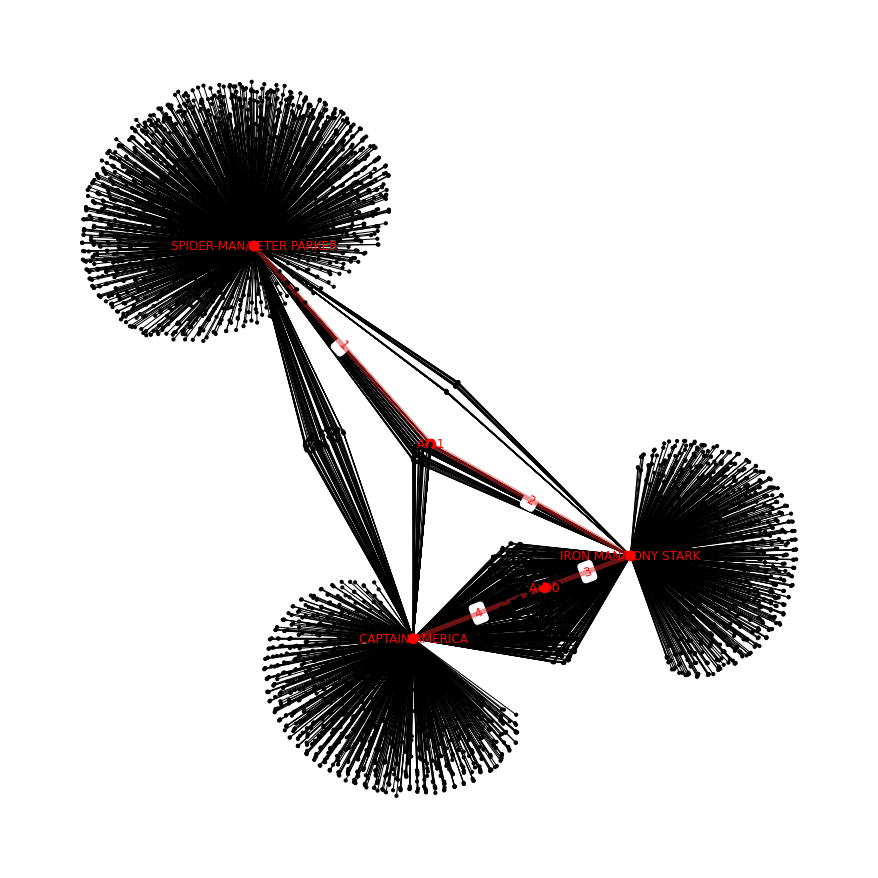

In [94]:
import pylab 
edge_label = ['1']
pos = nx.spring_layout(G2_top_N)
plt.figure(3,figsize=(12,12))
nx.draw(G2_top_N,pos,node_color = color,node_size = size,with_labels=False)
nx.draw_networkx_labels(G2_top_N,pos,labels,font_size=12,font_color='r')
nx.draw_networkx_edge_labels(G2_top_N,pos,edge_labels=edge_labels,font_color='r', font_size= 12)
nx.draw_networkx_edges(
    G2_top_N,
    pos,
    edgelist=edge_list,
    width=5,
    alpha=0.5,
    edge_color="tab:red",
)
plt.show()

## vecchio codice

In [ ]:
# PROVA
nodes = set(nx.all_neighbors(G2,'3-D MAN/CHARLES CHAN' ))
nodes.add('3-D MAN/CHARLES CHAN')
l = list(nx.all_neighbors(G2,'ROSS, GEN. THADDEUS' ))
for i in l:
    nodes.add(i)
nodes.add('ROSS, GEN. THADDEUS')
len(nodes)
G2_new = G2.subgraph(nodes)

In [96]:
def top_N(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    
    new_nodes = set(nodes)
    for i in nodes:
        app = list(df_edges.loc[df_edges['hero']==i]['comic'])
        new_nodes.update(app)
        
    G_top_N = G.subgraph(new_nodes)
    return G_top_N

In [97]:
def shortest_path(G2,node,path,final_node,visited,shortest_one,att):
    if node == final_node and att[node]=='hero':
        path.append(node)
        if len(path) < len(shortest_one):
            shortest_one = path.copy()
        path.pop(len(path)-1)
        return shortest_one
    
    else:
        for new_node in list(nx.all_neighbors(G2, node)):
            if new_node not in visited:
                if att[new_node]=='comic':
                    path.append(new_node)
                visited.append(new_node)
                shortest_one = shortest_path(G2,new_node,path,final_node,visited,shortest_one,att)
                if att[new_node]=='comic':
                    path.pop(len(path)-1)
                visited.pop(len(visited)-1)   
        return shortest_one

In [98]:
def functionality_3(G2, N, h_1, h_2):
    if N:
        N = int(N)
        G2 = top_N(df_edges,N,G2)
    att = nx.get_node_attributes(G2, "type")
    if not nx.is_connected(G2):
        result = 'There is not such path because the graph is not connected'
        return result
    if h_1  not in list(G2.nodes) or h_2 not in list(G2.nodes):
        result = 'There is not such path'
        return result
    shortest_one = list(range(0,len(G2.nodes)))
    shortest_one = shortest_path(G2,h_1,[h_1],h_2,[h_1],shortest_one,att)
    return shortest_one

In [104]:
N = input()

5


In [105]:
print(functionality_3(G2,N,'SPIDER-MAN/PETER PARKER','THOR/DR. DONALD BLAK'))

['SPIDER-MAN/PETER PARKER', 'CAPTAIN AMERICA', 'IRON MAN/TONY STARK', 'THING/BENJAMIN J. GR', 'THOR/DR. DONALD BLAK']


KeyboardInterrupt: 

In [48]:
print(functionality_3(G2_new,N,'3-D MAN/CHARLES CHAN','ROSS, GEN. THADDEUS'))

['3-D MAN/CHARLES CHAN', 'H2 251', 'ROSS, GEN. THADDEUS']


In [35]:
nx.shortest_path(G2, source='THOR/DR. DONALD BLAK', target='SPIDER-MAN/PETER PARKER', weight=None)

['THOR/DR. DONALD BLAK', 'A 11', 'SPIDER-MAN/PETER PARKER']

In [45]:
nx.shortest_path(G, source='3-D MAN/CHARLES CHAN', target='ROSS, GEN. THADDEUS', weight=None)

['3-D MAN/CHARLES CHAN', 'H2 251', 'ROSS, GEN. THADDEUS']

# Functionality 5 - Extracting Communities

Input:

- The graph data
- N: denoting the top N heroes that their data should be considered
- Hero_1: denoting the name of one of the heroes
- Hero_2: denoting the name of one of the heroes

Output:

- The minimum number of edges that should be removed to form communities
- A list of communities, each containing a list of heroes that belong to them.
- If the Hero_1 and Hero_2 belongs to the same community

Important Notes:  
This functionality should only be run on the first graph.

In [169]:
def top_N_1(df,N,G):
    df_new = df.groupby(['hero'])['hero'].count().reset_index(name="count")
    df_new= df_new.sort_values(by = 'count',ascending=False)
    df_new = df_new.head(N)
    nodes=[df_new['hero'][i] for i in df_new.index]
    G_top_N = G.subgraph(nodes)
    return G_top_N

In [170]:
def edges_to_remove(G):
    
    num_components = nx.number_connected_components(G)
    
    edges_to_remove = 0
    while True:
        if num_components > 1:
                break
        G_dict = {}
        G_dict = nx.edge_betweenness_centrality(G)
        max_EBC = max(G_dict.values())
        edges = []
        for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
            if value < max_EBC:
                break
            edges.append(key)
        edges_to_remove += len(edge)
        for e in edges:
            G.remove_edge(e[0], e[1])
        components = nx.connected_components(G)
        num_components = nx.number_connected_components(G)
    return edges_to_remove, G

In [171]:
def functionality_5(G1,N, Hero_1, Hero_2):
    G_top_N = top_N_1(df_edges,N,G1)
    G = nx.Graph(G_top_N)
    
    hero_1_2_together = False
    number_of_edges, G = edges_to_remove(G)
    comunities = []
    for comunity in nx.connected_components(G):
        comunities.append(list(comunity))
        if Hero_1 in comunity and Hero_2 in comunity:
            hero_1_2_together = True
    

    return number_of_edges, G, comunities, hero_1_2_together, G_top_N

# Visualization 5 - Visualize the communities

We anticipate seeing the Functionality 5 report in Visualization 5. To be more specific, we expect you to have the following report format:

- Print the number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot the original graph
- Plot the graph showing the communities in the network
- Plot the final graph and identify the community/communities of Hero_1 and Hero_2

Notes:  

For the final output of your function, please set the Hero_1 to 'Captain America' and Hero_2 to 'Ironman' and show the results
If Hero_1 and Hero_2 belong to the same community, identify that community; otherwise, identify those two communities that these heroes belong to.

In [172]:
Hero_1 = 'CAPTAIN AMERICA'
Hero_2 = 'IRON MAN/TONY STARK'
N = input()
N = int(N)

50


In [173]:
number_of_edges, G, comunities, hero_1_2, original_G= functionality_5(G1_weighted_graph,N,Hero_1,Hero_2)

#### number of links

In [174]:
print('The number of links that should be removed to have the communities is: ', number_of_edges)

The number of links that should be removed to have the communities is:  34


#### components of comunities

In [175]:
for i in range(len(comunities)):
    print('The components of the',i,'-th comunity are:')
    print(comunities[i])

The components of the 0 -th comunity are:
['HAWK', 'PROFESSOR X/CHARLES', 'ICEMAN/ROBERT BOBBY', 'IRON MAN/TONY STARK', 'RICHARDS, FRANKLIN B', 'THING/BENJAMIN J. GR', 'ODIN [ASGARDIAN]', 'SHADOWCAT/KATHERINE', 'BEAST/HENRY &HANK& P', 'JARVIS, EDWIN', 'WOLVERINE/LOGAN', 'BLACK WIDOW/NATASHA', 'JAMESON, J. JONAH', 'CAPTAIN BRITAIN/BRIA', 'INVISIBLE WOMAN/SUE', 'DR. DOOM/VICTOR VON', 'HERCULES [GREEK GOD]', 'THOR/DR. DONALD BLAK', 'VISION', 'COLOSSUS II/PETER RA', 'PARKER, MAY', 'ANT-MAN/DR. HENRY J.', 'SUB-MARINER/NAMOR MA', 'ROBERTSON, JOE', "BLACK PANTHER/T'CHAL", 'NIGHTCRAWLER/KURT WA', 'WONDER MAN/SIMON WIL', 'JONES, RICHARD MILHO', 'SILVER SURFER/NORRIN', 'WASP/JANET VAN DYNE', 'FURY, COL. NICHOLAS', 'HUMAN TORCH/JOHNNY S', 'QUICKSILVER/PIETRO M', 'HULK/DR. ROBERT BRUC', 'SHE-HULK/JENNIFER WA', 'WATSON-PARKER, MARY', 'CAPTAIN AMERICA', 'DR. STRANGE/STEPHEN', 'SPIDER-MAN/PETER PARKER', 'MR. FANTASTIC/REED R', 'MARVEL GIRL/JEAN GRE', 'PUNISHER II/FRANK CA', 'ANGEL/WARREN KENNETH', 'S

#### Hero_1 and Hero_2 are in the same comunity?

In [176]:
if hero_1_2:
    print(Hero_1,'and',Hero_2,'are in the same comunity')
else:
    print(Hero_1,'and',Hero_2,'are not in the same comunity')

CAPTAIN AMERICA and IRON MAN/TONY STARK are in the same comunity


#### Plot the original graph

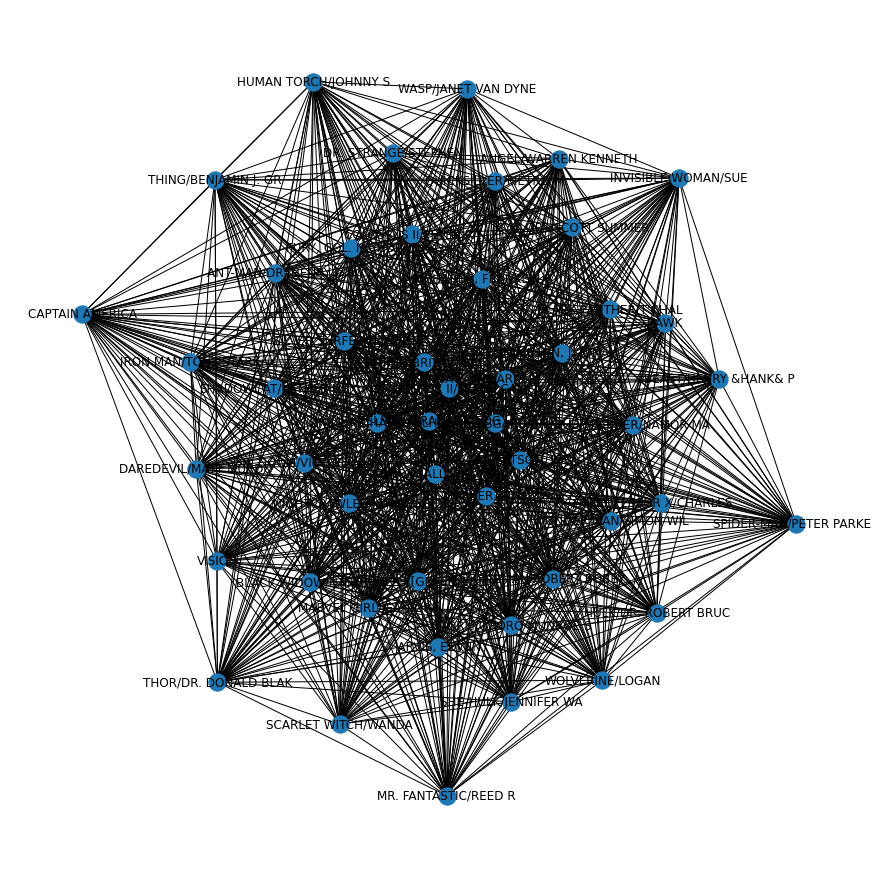

In [177]:
plt.figure(3,figsize=(12,12))
nx.draw(original_G, with_labels = True)
plt.show()

#### Plot the graph showing the communities in the network

In [178]:
import matplotlib.colors as mcolors
color=list(mcolors.CSS4_COLORS.keys())

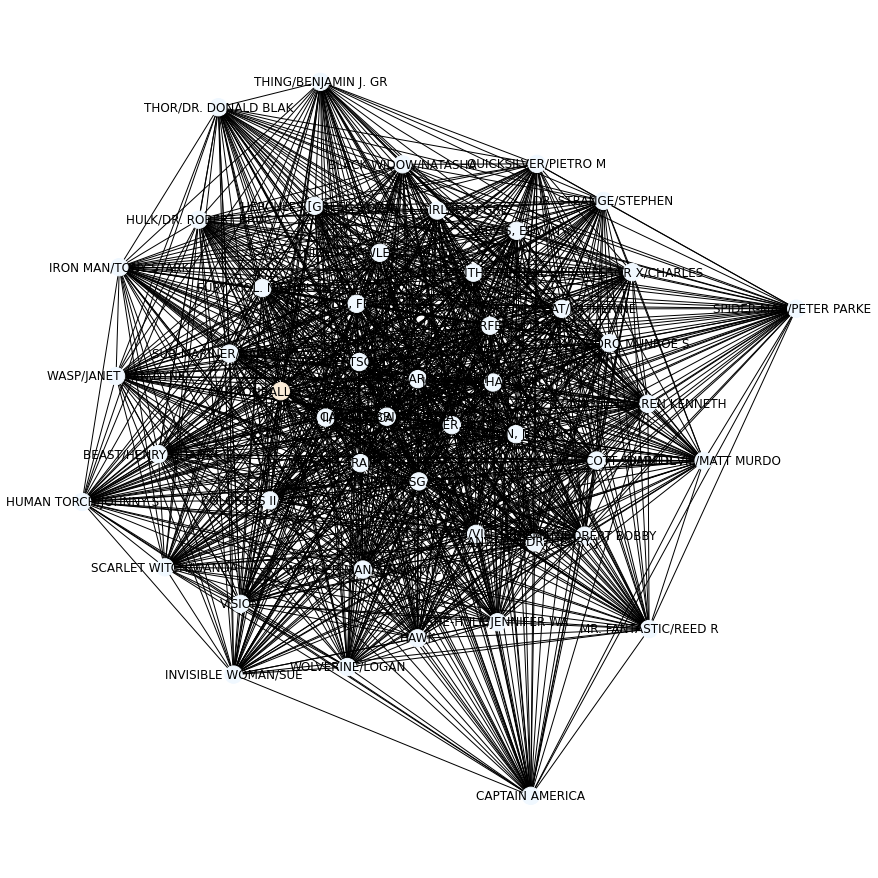

In [179]:
color_map = []
for node in G:
    for i in range(len(comunities)):
        if node in comunities[i]:
            color_map.append(color[i])
            break

plt.figure(3,figsize=(12,12))
nx.draw(original_G, node_color=color_map, with_labels=True)
plt.show()

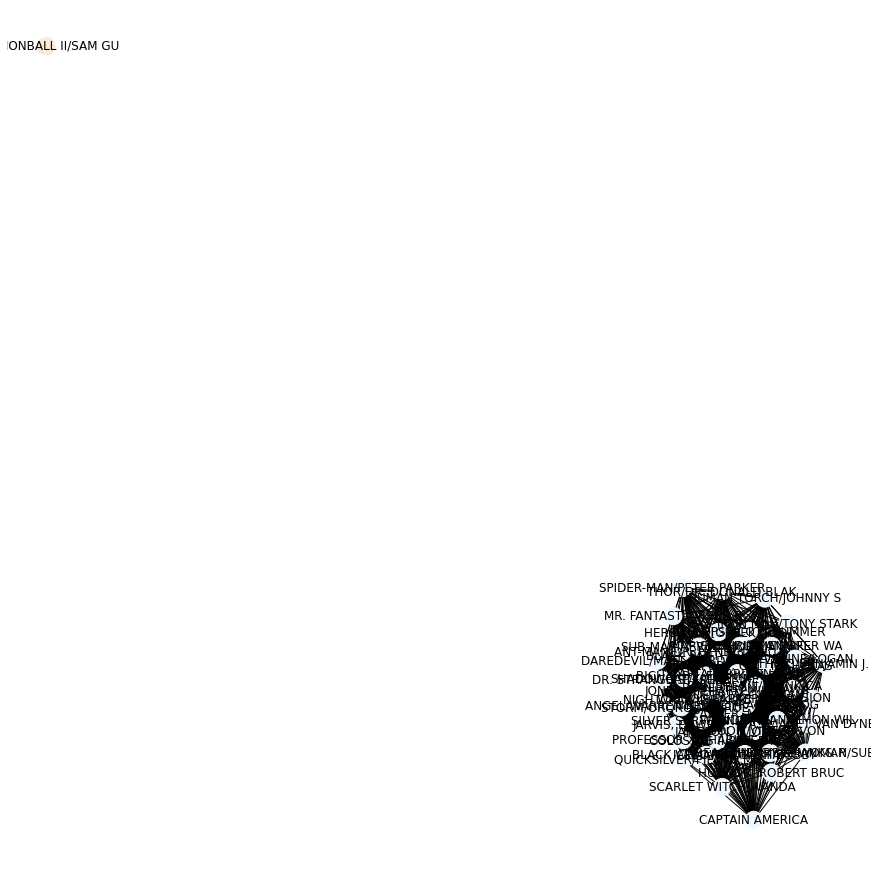

In [180]:
plt.figure(3,figsize=(12,12))
nx.draw(G, node_color=color_map, with_labels=True)
plt.show()

#### Plot the final graph and identify the community/communities of Hero_1 and Hero_2

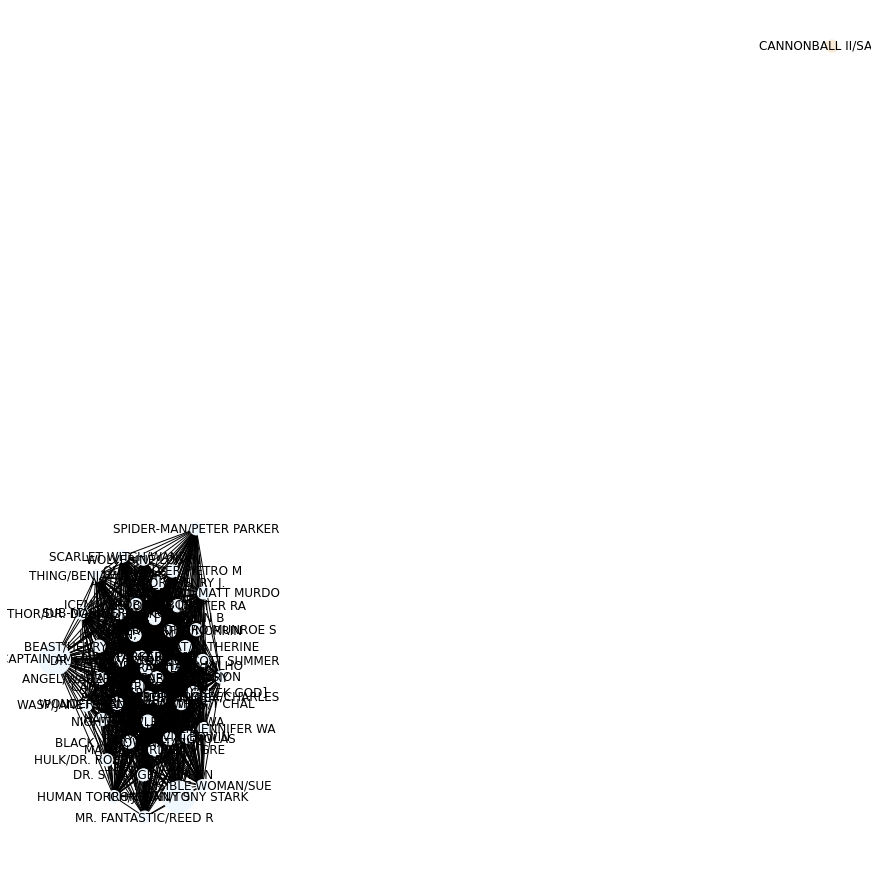

In [181]:
size = []
color_map = []

for node in G:
    for i in range(len(comunities)):
        if node in comunities[i]:
            if node == Hero_1 or node == Hero_2:
                size.append(1000)
            else:
                size.append(150)
            color_map.append(color[i])
            break         

plt.figure(3,figsize=(12,12))
nx.draw(G, node_color=color_map, node_size = size, with_labels=True)
plt.show()